This Notebook will leverage existing, out-of-the-box models to create some 
baseline models for the project.

The models will be evaluated using k-fold cross validation and the results 
will be compared to the results of the models created in the next notebook.

Note that although the models are out-of-the-box, they are based on the feature 
engineering efforts in the first notebook, and they will be tuned to optimize 
the results => These baseline models are reasonably competitive

In [1]:
import sys
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, classification_report

In [3]:
IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
#     subprocess.run('pip install -U lightgbm'.split(" "))

# find gpu device
GPU_AVAILABLE = torch.cuda.is_available()

RANDOM_SEED = 42

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Colab environment")
    d_path = "./drive/MyDrive/data/sequence-embeddings/"
else:
    print("Local environment")
    d_path = "./data/"

# Load the data
features = pd.read_csv(d_path + "features.csv")
labels = pd.read_csv(d_path + "labels.csv")
labels


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colab environment


,user_id,next_order_id,days_to_next_order,reorder_ratio,cls_days_to_next_order,cls_reorder_ratio
0,1,1187899,14.0,0.909091,1,3
1,2,1492625,30.0,0.387097,3,1
2,3,1402502,15.0,1.000000,2,3
3,4,2557754,0.0,0.000000,0,0
4,5,2196797,6.0,0.444444,0,1
...,...,...,...,...,...,...
206204,206205,1716008,10.0,0.315789,1,1
206205,206206,1904200,11.0,1.000000,1,3
206206,206207,1005822,18.0,1.000000,2,3
206207,206208,1882108,7.0,0.823529,1,2


In [5]:
print("Features with null values: ")
features.isna().sum()[features.isna().sum() > 0]

Features with null values: 


user_days_since_std    8686
dtype: int64

In [6]:
# Only user_days_since_std has missing values - fill with 0
features = features.fillna(0)

In [7]:
features.sort_values("user_id", inplace=True)
labels.sort_values("user_id", inplace=True)
print(features.shape, labels.shape)
features.drop("user_id", axis=1, inplace=True)
labels.drop("user_id", axis=1, inplace=True)
print(features.shape, labels.shape)

(206209, 55) (206209, 6)
(206209, 54) (206209, 5)


In [8]:
# As we will try a lot of different models, we will standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)
np.std(features, axis=0)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [9]:
# Models to try:
# 1. Logistic Regression one-vs-rest
# 2. Random Forest
# 3. Neural Network
# 4. Gradient Boosting

In [10]:
def ml_pipeline(model_class, init_params, X, y, param_distributions, n_folds=5, n_iter=10, n_jobs=-1, random_state=RANDOM_SEED):
    """
    Run a machine learning pipeline with cross-validation.
    Input:
        model_class: class of model to use, must be sklearn compatible
        init_params: dictionary of parameters to pass to model_class
        X: features, shape (n_samples, n_features)
        y: labels for one task, shape (n_samples,)
        params: dictionary of parameters to use in randomized search
        n_folds: number of folds to use for cross-validation
    Return:
        - best_model
        - best_params
        - best_score
    """
    clf = model_class(**init_params)
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
    scorer = make_scorer(f1_score, average="macro")
    searcher = RandomizedSearchCV(clf, param_distributions=param_distributions, 
        cv=cv, scoring=scorer, n_iter=n_iter, refit=False,
        error_score='raise', n_jobs=n_jobs, verbose=1, random_state=random_state
        )
    cv_results = searcher.fit(X, y)
    # best_model = searcher.best_estimator_
    best_params = searcher.best_params_
    best_score = searcher.best_score_
    return cv_results, best_params, best_score

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier


class LGBMClassifierEarlyStopping(LGBMClassifier):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
    
    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
        eval_set = [(X_val, y_val)]
        super().fit(X_train, y_train, eval_set=eval_set, verbose=False)

all_models = {
    "logistic_regression": {
        "model_class": LogisticRegression,
        "init_params": {
            "multi_class": "auto",
            "solver": "saga",
            "random_state": RANDOM_SEED,
            "max_iter": 1000,
        },
        "param_distributions": {
            "C": np.logspace(-3, 3, 7),
            "penalty": ["l1", "l2", "none"],
            "class_weight": [None, "balanced"],
            
        }
    },
    "lightgbm": {
        "model_class": LGBMClassifierEarlyStopping,
        "init_params": {
            "n_estimators": 1000, # early stopping will stop training before this
            "n_jobs": -1,
            "early_stopping_rounds": 10,
            "random_state": RANDOM_SEED
        },
        "param_distributions": {
            "max_depth": [5, 10, 15, 20],
            "learning_rate": np.logspace(-5, 0, 10),
            "num_leaves": np.logspace(3, 8, 10, base=2, dtype=int),
            "min_child_samples": [2, 5, 10, 20, 50, 100],
            "class_weight": [None, "balanced"],
            "reg_alpha": [0, 0.1, 0.01, 0.001, 0.0001],
            "reg_lambda": [0, 0.1, 0.01, 0.001, 0.0001],
        }
    },
    "random_forest": {
        "model_class": RandomForestClassifier,
        "init_params": {
            "n_estimators": 100,
            "random_state": RANDOM_SEED
        },
        "param_distributions": {
            "max_depth": [5, 10, 15, 20],
            "min_samples_split": [5, 10, 20, 50],
            "min_samples_leaf": [1, 2, 5, 10],
            "max_features": ["sqrt", "log2"],
            "class_weight": [None, "balanced"],
        }
    },
    "mlp": {
        "model_class": MLPClassifier,
        "init_params": {
            "random_state": RANDOM_SEED,
            "solver": "adam",
            "tol": 1e-4,
            "early_stopping": True,
            "max_iter": 200
        },
        "param_distributions": {
            "hidden_layer_sizes": [(100,), (100, 100), (100, 100, 100), (200,), (200, 200), (200, 200, 200)],
            "activation": ["logistic", "relu"],
            "alpha": np.logspace(-5, 0, 6),
            "learning_rate": ["constant", "invscaling", "adaptive"],
            "learning_rate_init": np.logspace(-4, -1, 4)
        }
    }
}

In [19]:
# Set aside 10% of the data for final evaluation
# Use the remaining 90% for training and validation
X_train, X_test, Y_train, Y_test = train_test_split(
    features, 
    labels[["cls_days_to_next_order","cls_reorder_ratio"]], 
    test_size=0.1, 
    random_state=RANDOM_SEED
    )

In [20]:
Y_train.head()

,cls_days_to_next_order,cls_reorder_ratio
170013,2,1
65476,2,2
92306,3,1
19297,2,2
133164,1,2


In [21]:
tuning_results_1 = {}

In [22]:
# Hyperparameter tuning
# Apply ml_pipeline to task #1: cls_days_to_next_order

for name, model_details in all_models.items():
    print(f"Training {name}...")
    cv_results, best_params, best_score = ml_pipeline(
        model_class=model_details["model_class"],
        init_params=model_details["init_params"],
        X=X_train, 
        y=Y_train["cls_days_to_next_order"],
        param_distributions=model_details["param_distributions"],
        n_folds=5,
        n_iter=10
    )
    print(f"Best params: {best_params}")
    print(f"Best score: {best_score}")
    tuning_results_1[name] = {
        "cv_results": cv_results,
        "best_params": best_params,
        "best_score": best_score
    }

Training logistic_regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'penalty': 'l1', 'class_weight': 'balanced', 'C': 1000.0}
Best score: 0.40093155931738467
Training lightgbm...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'reg_lambda': 0.0001, 'reg_alpha': 0.001, 'num_leaves': 118, 'min_child_samples': 2, 'max_depth': 10, 'learning_rate': 0.07742636826811278, 'class_weight': 'balanced'}
Best score: 0.42082584432693826
Training random_forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params: {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': 'balanced'}
Best score: 0.4154807820164793
Training mlp...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params: {'learning_rate_init': 0.001, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (200, 200), 'alpha': 1e-05, 'activation': 'relu'}
Best score: 0.39202614827296006


In [23]:
tuning_results_1

{'logistic_regression': {'cv_results': RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     error_score='raise',
                     estimator=LogisticRegression(max_iter=1000, random_state=42,
                                                  solver='saga'),
                     n_jobs=-1,
                     param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                          'class_weight': [None, 'balanced'],
                                          'penalty': ['l1', 'l2', 'none']},
                     random_state=42, refit=False,
                     scoring=make_scorer(f1_score, average=macro), verbose=1),
  'best_params': {'penalty': 'l1', 'class_weight': 'balanced', 'C': 1000.0},
  'best_score': 0.40093155931738467},
 'lightgbm': {'cv_results': RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     error_score='ra

In [24]:
import pickle
with open(d_path + "tuning_results_1.pkl", "wb") as f:
    pickle.dump(tuning_results_1, f)


In [25]:
# Hyperparameter tuning
# Apply ml_pipeline to task #2: cls_reorder_ratio
tuning_results_2 = {}
for name, model_details in all_models.items():
    print(f"Training {name}...")
    cv_results, best_params, best_score = ml_pipeline(
        model_class=model_details["model_class"],
        init_params=model_details["init_params"],
        X=X_train, 
        y=Y_train["cls_reorder_ratio"],
        param_distributions=model_details["param_distributions"],
        n_folds=5,
        n_iter=10
    )
    print(f"Best params: {best_params}")
    print(f"Best score: {best_score}")
    tuning_results_2[name] = {
        "cv_results": cv_results,
        "best_params": best_params,
        "best_score": best_score
    }

Training logistic_regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'penalty': 'l1', 'class_weight': 'balanced', 'C': 1000.0}
Best score: 0.42818345854469475
Training lightgbm...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'reg_lambda': 0.0001, 'reg_alpha': 0.001, 'num_leaves': 118, 'min_child_samples': 2, 'max_depth': 10, 'learning_rate': 0.07742636826811278, 'class_weight': 'balanced'}
Best score: 0.45836202728999637
Training random_forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params: {'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}
Best score: 0.4707900262724459
Training mlp...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100), 'alpha': 0.1, 'activation': 'logistic'}
Best score: 0.44935031908268297


In [26]:
import pickle
with open(d_path + "tuning_results_2.pkl", "wb") as f:
    pickle.dump(tuning_results_2, f)


In [27]:
tuning_results_2

{'logistic_regression': {'cv_results': RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     error_score='raise',
                     estimator=LogisticRegression(max_iter=1000, random_state=42,
                                                  solver='saga'),
                     n_jobs=-1,
                     param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                          'class_weight': [None, 'balanced'],
                                          'penalty': ['l1', 'l2', 'none']},
                     random_state=42, refit=False,
                     scoring=make_scorer(f1_score, average=macro), verbose=1),
  'best_params': {'penalty': 'l1', 'class_weight': 'balanced', 'C': 1000.0},
  'best_score': 0.42818345854469475},
 'lightgbm': {'cv_results': RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     error_score='ra

# Evaluation

In [31]:
# For cls_days_to_next_order task
{model:{"best_params": result["best_params"],
        "best_score": result["best_score"]} for model, result in tuning_results_1.items()}

{'logistic_regression': {'best_params': {'penalty': 'l1',
   'class_weight': 'balanced',
   'C': 1000.0},
  'best_score': 0.40093155931738467},
 'lightgbm': {'best_params': {'reg_lambda': 0.0001,
   'reg_alpha': 0.001,
   'num_leaves': 118,
   'min_child_samples': 2,
   'max_depth': 10,
   'learning_rate': 0.07742636826811278,
   'class_weight': 'balanced'},
  'best_score': 0.42082584432693826},
 'random_forest': {'best_params': {'min_samples_split': 20,
   'min_samples_leaf': 10,
   'max_features': 'sqrt',
   'max_depth': 15,
   'class_weight': 'balanced'},
  'best_score': 0.4154807820164793},
 'mlp': {'best_params': {'learning_rate_init': 0.001,
   'learning_rate': 'invscaling',
   'hidden_layer_sizes': (200, 200),
   'alpha': 1e-05,
   'activation': 'relu'},
  'best_score': 0.39202614827296006}}

In [38]:
task1_cv = pd.DataFrame({model:{"best_params": result["best_params"],
        "best_score": result["best_score"]} for model, result in tuning_results_1.items()}).T
task1_cv.reset_index(inplace=True)
task1_cv.rename(columns={"index":"model_type"}, inplace=True)
task1_cv

,model_type,best_params,best_score
0,logistic_regression,"{'penalty': 'l1', 'class_weight': 'balanced', ...",0.400932
1,lightgbm,"{'reg_lambda': 0.0001, 'reg_alpha': 0.001, 'nu...",0.420826
2,random_forest,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.415481
3,mlp,"{'learning_rate_init': 0.001, 'learning_rate':...",0.392026


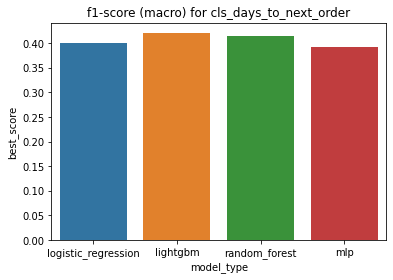

In [42]:
sns.barplot(x="model_type", y="best_score", data=task1_cv)
plt.title("f1-score (macro) for cls_days_to_next_order")
plt.show()

In [40]:
task2_cv = pd.DataFrame({model:{"best_params": result["best_params"],
        "best_score": result["best_score"]} for model, result in tuning_results_2.items()}).T
task2_cv.reset_index(inplace=True)
task2_cv.rename(columns={"index":"model_type"}, inplace=True)
task2_cv

,model_type,best_params,best_score
0,logistic_regression,"{'penalty': 'l1', 'class_weight': 'balanced', ...",0.428183
1,lightgbm,"{'reg_lambda': 0.0001, 'reg_alpha': 0.001, 'nu...",0.458362
2,random_forest,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.47079
3,mlp,"{'learning_rate_init': 0.001, 'learning_rate':...",0.44935


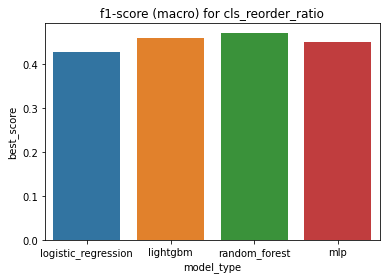

In [43]:
sns.barplot(x="model_type", y="best_score", data=task2_cv)
plt.title("f1-score (macro) for cls_reorder_ratio")
plt.show()

In [48]:
from utils import auc_report, evaluate

In [53]:
import utils

In [55]:
import importlib
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

Evaluating model
              precision    recall  f1-score   support

           0       0.43      0.55      0.48      4587
           1       0.41      0.28      0.33      5762
           2       0.29      0.20      0.24      4380
           3       0.47      0.62      0.54      5892

    accuracy                           0.42     20621
   macro avg       0.40      0.41      0.40     20621
weighted avg       0.41      0.42      0.40     20621

0: 0.7488951630716927
1: 0.6447946226170104
2: 0.609174536849211
3: 0.7490585281946285


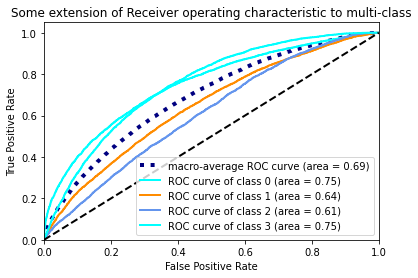

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Evaluating model
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      4587
           1       0.43      0.32      0.36      5762
           2       0.30      0.26      0.27      4380
           3       0.48      0.62      0.54      5892

    accuracy                           0.44     20621
   macro avg       0.42      0.43      0.42     20621
weighted avg       0.43      0.44      0.43     20621

0: 0.7649349013877449
1: 0.6599115686060562
2: 0.6300073746499291
3: 0.7589258795831473


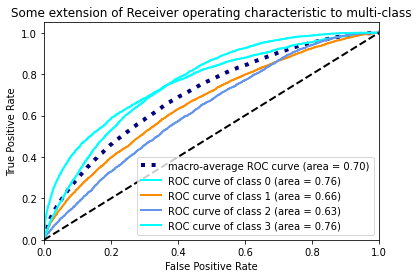

Evaluating model
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      4587
           1       0.41      0.33      0.37      5762
           2       0.29      0.23      0.25      4380
           3       0.46      0.65      0.54      5892

    accuracy                           0.43     20621
   macro avg       0.42      0.42      0.41     20621
weighted avg       0.42      0.43      0.42     20621

0: 0.7573070077622005
1: 0.6537248819920792
2: 0.6230309501939817
3: 0.7530673885201005


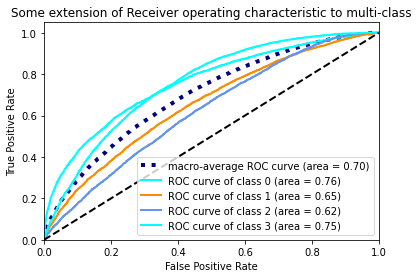

Evaluating model
              precision    recall  f1-score   support

           0       0.52      0.43      0.47      4587
           1       0.41      0.39      0.40      5762
           2       0.34      0.07      0.11      4380
           3       0.43      0.77      0.56      5892

    accuracy                           0.44     20621
   macro avg       0.43      0.42      0.39     20621
weighted avg       0.43      0.44      0.40     20621

0: 0.7574714310899019
1: 0.6521413166210603
2: 0.6108430127370861
3: 0.7515082515675717


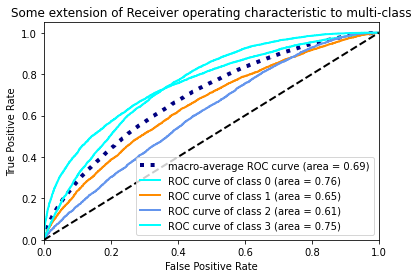

In [56]:
# Evaluate auc
# For cls_days_to_next_order task
for name, details in all_models.items():
    model = details["model_class"](**details["init_params"], **tuning_results_1[name]["best_params"])
    model.fit(X_train, Y_train["cls_days_to_next_order"])
    utils.evaluate(model, X_test, Y_test["cls_days_to_next_order"])

Evaluating model
              precision    recall  f1-score   support

           0       0.22      0.61      0.32      1554
           1       0.47      0.43      0.45      5380
           2       0.63      0.38      0.47      9041
           3       0.43      0.55      0.48      4646

    accuracy                           0.45     20621
   macro avg       0.44      0.49      0.43     20621
weighted avg       0.51      0.45      0.46     20621

0: 0.8167574965445632
1: 0.7441378408709242
2: 0.6809540265522311
3: 0.7394854745731769


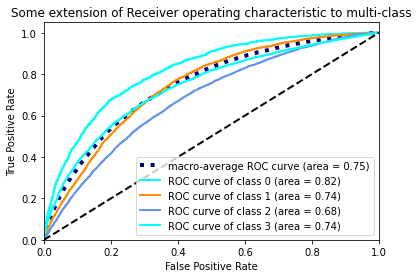

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Evaluating model
              precision    recall  f1-score   support

           0       0.26      0.54      0.35      1554
           1       0.46      0.49      0.47      5380
           2       0.62      0.44      0.51      9041
           3       0.46      0.53      0.49      4646

    accuracy                           0.48     20621
   macro avg       0.45      0.50      0.46     20621
weighted avg       0.52      0.48      0.49     20621

0: 0.8292921749417266
1: 0.7456848444166817
2: 0.6957617944275731
3: 0.7585339770964237


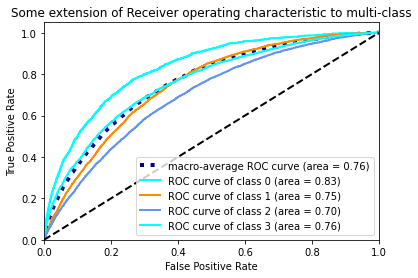

Evaluating model
              precision    recall  f1-score   support

           0       0.34      0.35      0.34      1554
           1       0.47      0.58      0.52      5380
           2       0.60      0.50      0.55      9041
           3       0.48      0.51      0.49      4646

    accuracy                           0.51     20621
   macro avg       0.47      0.48      0.48     20621
weighted avg       0.52      0.51      0.51     20621

0: 0.8253191904264439
1: 0.7516220554564592
2: 0.6916736536434768
3: 0.761338415531694


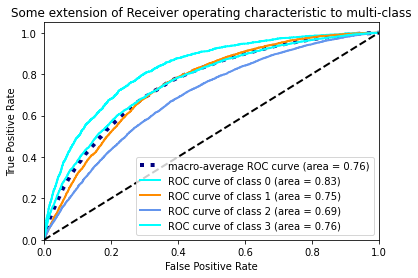

Evaluating model
              precision    recall  f1-score   support

           0       0.41      0.21      0.27      1554
           1       0.49      0.48      0.49      5380
           2       0.56      0.68      0.62      9041
           3       0.53      0.41      0.46      4646

    accuracy                           0.53     20621
   macro avg       0.50      0.45      0.46     20621
weighted avg       0.53      0.53      0.52     20621

0: 0.8253651571687971
1: 0.7554786065467609
2: 0.6936198156202247
3: 0.7646930706542792


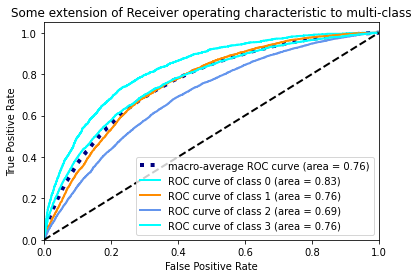

In [57]:
# Evaluate auc
# For cls_reorder_ratio task
for name, details in all_models.items():
    model = details["model_class"](**details["init_params"], **tuning_results_2[name]["best_params"])
    model.fit(X_train, Y_train["cls_reorder_ratio"])
    utils.evaluate(model, X_test, Y_test["cls_reorder_ratio"])